## 1. Импорт библиотек

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd

## 2. Загрузка изображения и выделение каналов R, G, B



### 2.1 Работа с изображением

Задаем путь до изображения

In [2]:
image_path = 'C:/Users/5fedo/Jupyter/NM/Mass Effect_picture.jpg'

Загрузка изображения

In [3]:
img = mpimg.imread(image_path)

Приводим данные к типу float64 и нормализуем

In [4]:
img = img.astype(np.float64) / 255.0

In [5]:
print("Тип данных:", img.dtype)

Тип данных: float64


In [6]:
img.shape

(4416, 2944, 3)

Разделим на 3 матрицы

In [7]:
R = img[:, :, 0]  # красный 
G = img[:, :, 1]  # зелёный 
B = img[:, :, 2]  # синий 

### 2.2 Визуализация

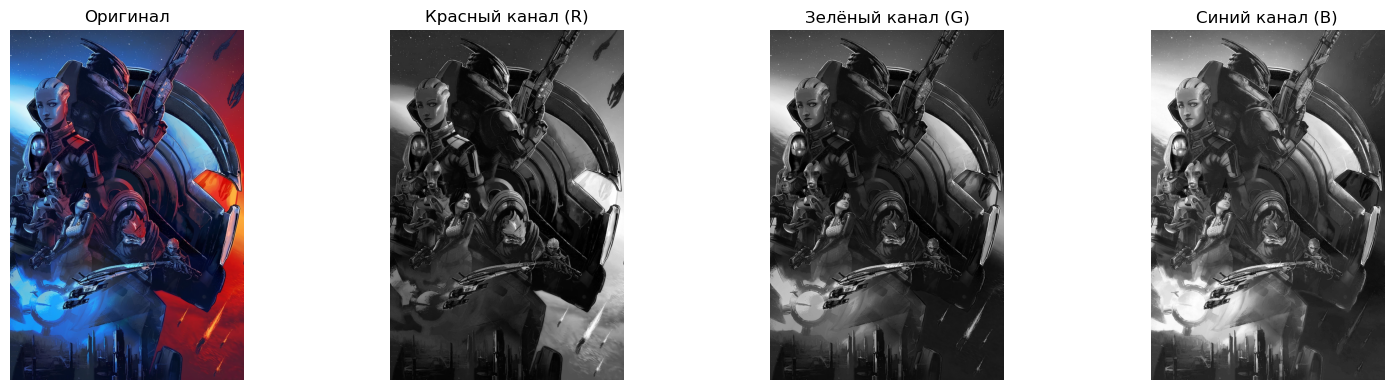

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title('Оригинал')
axes[0].axis('off')

axes[1].imshow(R, cmap='gray')
axes[1].set_title('Красный канал (R)')
axes[1].axis('off')

axes[2].imshow(G, cmap='gray')
axes[2].set_title('Зелёный канал (G)')
axes[2].axis('off')

axes[3].imshow(B, cmap='gray')
axes[3].set_title('Синий канал (B)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

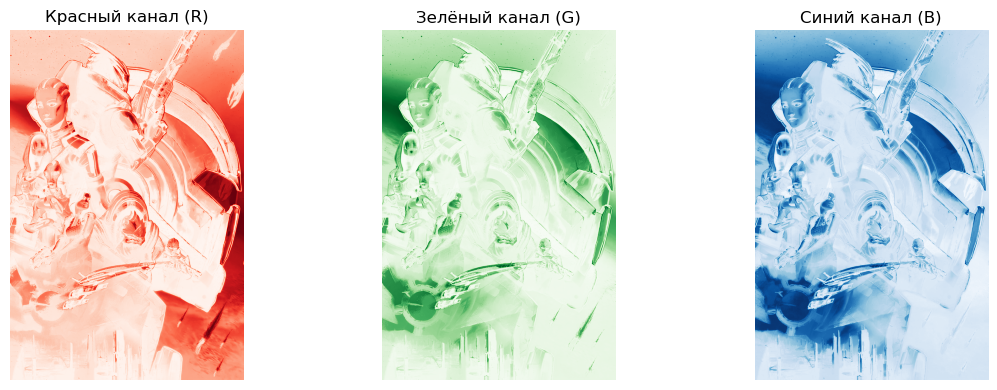

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(R, cmap='Reds')
axes[0].set_title('Красный канал (R)')
axes[0].axis('off')

axes[1].imshow(G, cmap='Greens')
axes[1].set_title('Зелёный канал (G)')
axes[1].axis('off')

axes[2].imshow(B, cmap='Blues')
axes[2].set_title('Синий канал (B)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

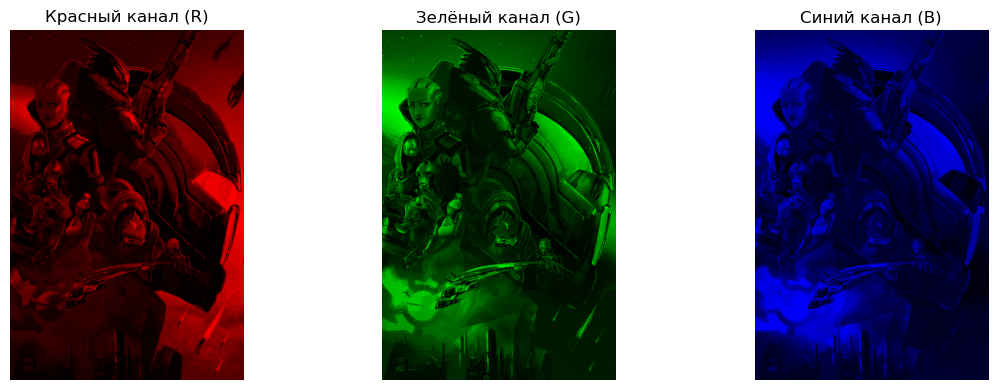

In [10]:
zeros = np.zeros_like(R) 

red_only   = np.stack([R,  zeros, zeros], axis=2)
green_only = np.stack([zeros, G,  zeros], axis=2)
blue_only  = np.stack([zeros, zeros, B ], axis=2)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(red_only)
axes[0].set_title('Красный канал (R)')
axes[0].axis('off')

axes[1].imshow(green_only)
axes[1].set_title('Зелёный канал (G)')
axes[1].axis('off')

axes[2].imshow(blue_only)
axes[2].set_title('Синий канал (B)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 3. Степенной метод

### 3.1 Реализация функции

`Вычисляет наибольшее сингулярное число и соответствующие сингулярные векторы матрицы A с применением степенного метода`

---

**Параметры:**
    
* `A` : np.ndarray, shape (m, n), dtype - float64
  
    > Исходная матрица (например, цветовой канал высотой m и шириной n).
  
* `num_iters` : int
  
   > Максимальное число итераций степенного метода.
  
* `tol` : float
 
   > Порог для критерия остановки: если *||v_new - v_old||* < tol, остановиться.
  
* `verbose` : bool
   > Если True, печатать прогресс (номер итерации и приближённое значение sigma).

---

**Возвращает:**

* `sigma` : float
  
  >  Приближённое наибольшее сингулярное число (>= 0).
  
* `u` : np.ndarray, shape (m,)

  >   Приближённый левый сингулярный вектор, ||u||_2 = 1.


* `v` : np.ndarray, shape (n,)

  
  >  Приближённый правый сингулярный вектор, ||v||_2 = 1.

In [41]:
def step_method_for_svd(A: np.ndarray, num_iters: int = 500, tol: float = 1e-6, verbose: bool = False):
    
    # Размеры A
    m, n = A.shape

    # Инициализируем правый сингулярный нормированный вектор v случайным образом
    v = np.random.randn(n).astype(np.float64)
    v = v / np.linalg.norm(v)

    sigma_vals = [] 
    
    # Итеративный процесс:
    sigma_old = 0.0
    for k in range(num_iters):
        # Вычисляем y = A * v  (размер m)
        y = np.dot(A, v)

        # Вычисляем z = A^T * y  (размер n)
        z = np.dot(A.T, y)

        # Нормируем z, чтобы получить новый приближённый v_new
        norm_z = np.linalg.norm(z)
        
        if norm_z == 0:
            # Выродившийся случай: все значения нули => сингулярная величина 0
            return 0.0, np.zeros(m), np.zeros(n)

        v_new = z / norm_z
        
        # Текущее приближение σ₁ через ||A v_new||
        sigma_new = np.linalg.norm(A @ v_new)
        sigma_vals.append(sigma_new)

        # Критерий остановки
        if np.linalg.norm(v_new - v) < tol:
            v = v_new
            if verbose:
                print(f"Итерация {k+1:4d}: сходимость по вектору (||v_new - v_old|| = {np.linalg.norm(v_new - v):.2e}).")
            break
        

        # Обновляем для следующей итерации
        v = v_new
        sigma_old = sigma_new

        if verbose and (k + 1) % 50 == 0:
            print(f"Итерация {k+1:4d}: текущее приближение σ ≈ {sigma_new}")

    else:
        # Если не сработало условие tol
        sigma = sigma_new
        if verbose:
            print(f"Достигнут максимум итераций ({num_iters}). σ ≈ {sigma}")

    
    # Теперь у нас есть приближённый правый сингулярный вектор v и σ.
    # Вычислим левый сингулярный вектор u = (A * v) / σ.
    # При этом A * v = y (для последней итерации) — можем вычислить заново:
    y_final = np.dot(A, v)
    norm_y_final = np.linalg.norm(y_final)
    
    if norm_y_final == 0:
        # Вырождение 
        u = np.zeros(m)
    else:
        u = y_final / norm_y_final
        
    sigma = norm_y_final

    return sigma_vals, sigma, u, v

### 3.2 Применение функции к каналам R, G, B

 Параметры для функции:

In [42]:
max_iters = 1000
tol = 1e-10

**Канал R** 

In [43]:
%%time
sigma_vals_R, sigma_R, u_R, v_R = step_method_for_svd(R, num_iters=max_iters, tol=tol, verbose=True)

Итерация   11: сходимость по вектору (||v_new - v_old|| = 0.00e+00).
CPU times: total: 4.55 s
Wall time: 4.17 s


In [44]:
print(f"Канал R: σ_R ≈ {sigma_R:.6f}")
print(f"Размеры: u_R shape = {u_R.shape}, v_R shape = {v_R.shape}")

Канал R: σ_R ≈ 966.354004
Размеры: u_R shape = (4416,), v_R shape = (2944,)


**Канал G**

In [45]:
%%time
sigma_vals_G, sigma_G, u_G, v_G = step_method_for_svd(G, num_iters=max_iters, tol=tol, verbose=True)

Итерация   11: сходимость по вектору (||v_new - v_old|| = 0.00e+00).
CPU times: total: 4.08 s
Wall time: 4.08 s


In [46]:
print(f"Канал G: σ_G ≈ {sigma_G:.6f}")
print(f"Размеры: u_G shape = {u_G.shape}, v_G shape = {v_G.shape}")

Канал G: σ_G ≈ 876.295663
Размеры: u_G shape = (4416,), v_G shape = (2944,)


**Канал B**

In [47]:
%%time
sigma_vals_B, sigma_B, u_B, v_B = step_method_for_svd(B, num_iters=max_iters, tol=tol, verbose=True)

Итерация   11: сходимость по вектору (||v_new - v_old|| = 0.00e+00).
CPU times: total: 4.73 s
Wall time: 4.09 s


In [48]:
print(f"Канал B: σ_B ≈ {sigma_B:.6f}")
print(f"Размеры: u_B shape = {u_B.shape}, v_B shape = {v_B.shape}")

Канал B: σ_B ≈ 1350.566109
Размеры: u_B shape = (4416,), v_B shape = (2944,)


In [50]:
Ns = [1, 5, 10, 30]
tol = 1e-30

for N in Ns:
    # Канал R
    sigma_vals_R, sigma_R, u_R, v_R = step_method_for_svd(R, num_iters=N, tol=tol)
    R_approx = sigma_R * np.outer(u_R, v_R)
    err_R = np.linalg.norm(R - R_approx, ord='fro')

    # Канал G
    sigma_vals_G, sigma_G, u_G, v_G = step_method_for_svd(G, num_iters=N, tol=tol)
    G_approx = sigma_G * np.outer(u_G, v_G)
    err_G = np.linalg.norm(G - G_approx, ord='fro')

    # Канал B
    sigma_vals_B, sigma_B, u_B, v_B = step_method_for_svd(B, num_iters=N, tol=tol)
    B_approx = sigma_B * np.outer(u_B, v_B)
    err_B = np.linalg.norm(B - B_approx, ord='fro')

    print(f"\n=== N = {N} итераций ===")
    print(f"Канал R: σ = {sigma_R}, ‖R - σ*u*v^T‖_F = {err_R}")
    print(f"Канал G: σ = {sigma_G}, ‖G - σ*u*v^T‖_F = {err_G}")
    print(f"Канал B: σ = {sigma_B}, ‖B - σ*u*v^T‖_F = {err_B}")


=== N = 1 итераций ===
Канал R: σ = 952.5278595859724, ‖R - σ*u*v^T‖_F = 672.7650810575864
Канал G: σ = 860.2620595430451, ‖G - σ*u*v^T‖_F = 651.4223340505292
Канал B: σ = 1215.7793646447767, ‖B - σ*u*v^T‖_F = 936.5645162535521

=== N = 5 итераций ===
Канал R: σ = 966.3540028694986, ‖R - σ*u*v^T‖_F = 652.7496600657497
Канал G: σ = 876.295662994032, ‖G - σ*u*v^T‖_F = 629.6886368729637
Канал B: σ = 1350.5661089604578, ‖B - σ*u*v^T‖_F = 728.8646938415363

=== N = 10 итераций ===
Канал R: σ = 966.354003845593, ‖R - σ*u*v^T‖_F = 652.7496586207043
Канал G: σ = 876.2956629950318, ‖G - σ*u*v^T‖_F = 629.6886368715725
Канал B: σ = 1350.566108960464, ‖B - σ*u*v^T‖_F = 728.8646938415249

=== N = 30 итераций ===
Канал R: σ = 966.3540038455931, ‖R - σ*u*v^T‖_F = 652.7496586207047
Канал G: σ = 876.2956629950318, ‖G - σ*u*v^T‖_F = 629.6886368715723
Канал B: σ = 1350.566108960464, ‖B - σ*u*v^T‖_F = 728.864693841525


## 4. Низкоранговая аппроксимация

### 4.1 Функции

Вычисляем полный SVD для каждого канала

In [20]:
U_R, S_R, Vt_R = np.linalg.svd(R, full_matrices=False)
U_G, S_G, Vt_G = np.linalg.svd(G, full_matrices=False)
U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

График распределения сингулярных чисел каналов R, G, B

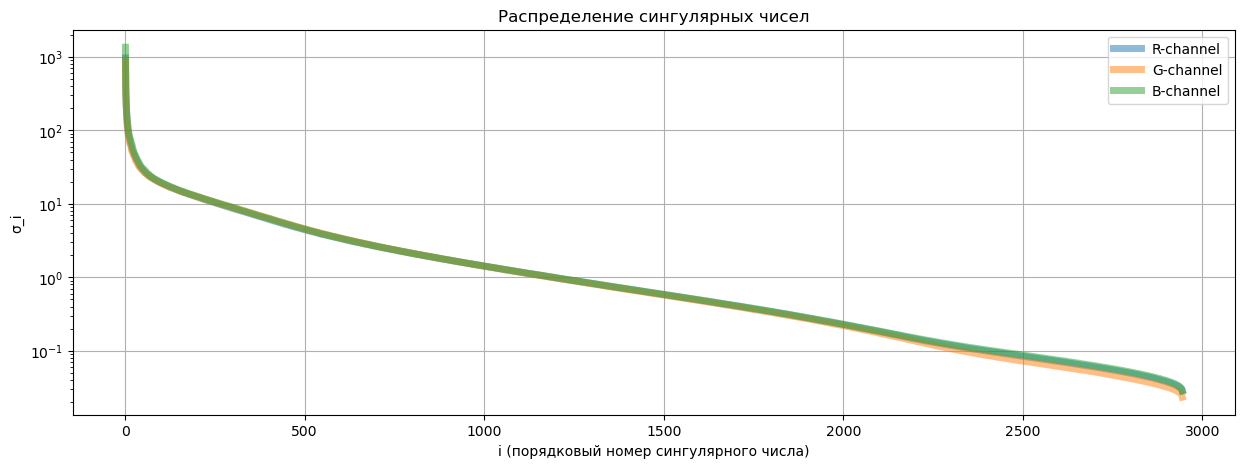

In [21]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(S_R)+1), S_R, label='R-channel', alpha = 0.5, linewidth = 5)
plt.plot(np.arange(1, len(S_G)+1), S_G, label='G-channel', alpha = 0.5, linewidth = 5)
plt.plot(np.arange(1, len(S_B)+1), S_B, label='B-channel', alpha = 0.5, linewidth = 5)
plt.xlabel('i (порядковый номер сингулярного числа)')
plt.ylabel('σ_i')
plt.title('Распределение сингулярных чисел')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

Функция для взятия первых k-компонент для аппроксимации

In [22]:
def low_rank_approximation(U, S, Vt, k: int):

    # Берём первые k сингулярных чисел и векторов
    U_k = U[:, :k]
    Sigma_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    # Умножаем обратно, получаем A_k
    A_k = U_k @ Sigma_k @ Vt_k 
    return A_k


Функция для сбора изображения 

In [23]:
def reconstruct_image(R_approx, G_approx, B_approx):
    
    # Стекуем каналы по третьей оси
    img_approx = np.dstack((R_approx, G_approx, B_approx))
    
    # Ограничим значения, чтобы не выходили за [0,1] из-за численных погрешностей
    img_approx = np.clip(img_approx, 0.0, 1.0)
    
    return img_approx

### 4.2 Тесты

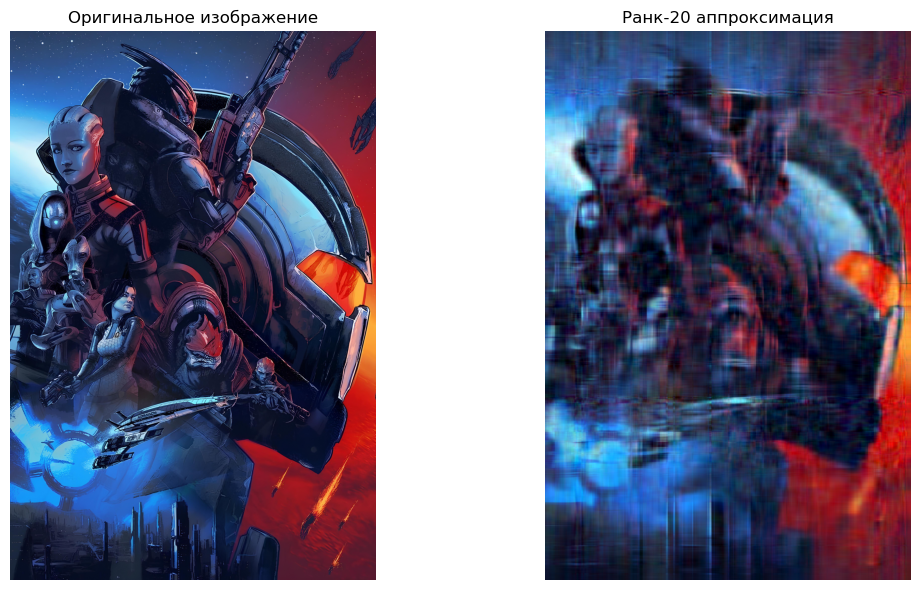

In [24]:
k = 20 

R_k = low_rank_approximation(U_R, S_R, Vt_R, k)
G_k = low_rank_approximation(U_G, S_G, Vt_G, k)
B_k = low_rank_approximation(U_B, S_B, Vt_B, k)

# Собираем цветное изображение из приближённых каналов
img_k = reconstruct_image(R_k, G_k, B_k)

# Визуализация: оригинал и приближение рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинал
axes[0].imshow(np.dstack((R, G, B)))
axes[0].set_title('Оригинальное изображение')
axes[0].axis('off')

# Ранковая аппроксимация
axes[1].imshow(img_k)
axes[1].set_title(f'Ранк-{k} аппроксимация')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Подсчет ошибок

In [25]:
err_R = np.linalg.norm(R - R_k, ord='fro')
err_G = np.linalg.norm(G - G_k, ord='fro')
err_B = np.linalg.norm(B - B_k, ord='fro')

err_total = np.sqrt(err_R**2 + err_G**2 + err_B**2)

print(f"Ошибка Фробениуса: R: {err_R:.4f}, G: {err_G:.4f}, B: {err_B:.4f}")
print(f"Суммарная ошибка: {err_total:.4f}")

Ошибка Фробениуса: R: 344.7461, G: 337.4626, B: 358.2586
Суммарная ошибка: 600.8994


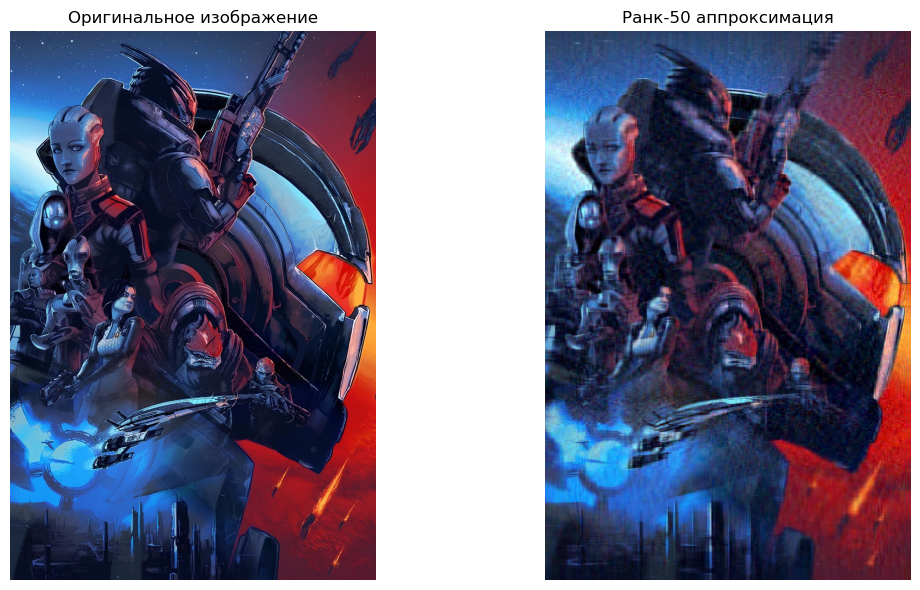

In [26]:
k = 50

R_k = low_rank_approximation(U_R, S_R, Vt_R, k)
G_k = low_rank_approximation(U_G, S_G, Vt_G, k)
B_k = low_rank_approximation(U_B, S_B, Vt_B, k)

# Собираем цветное изображение из приближённых каналов
img_k = reconstruct_image(R_k, G_k, B_k)

# Визуализация: оригинал и приближение рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинал
axes[0].imshow(np.dstack((R, G, B)))
axes[0].set_title('Оригинальное изображение')
axes[0].axis('off')

# Ранковая аппроксимация
axes[1].imshow(img_k)
axes[1].set_title(f'Ранк-{k} аппроксимация')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Подсчет ошибок

In [27]:
err_R = np.linalg.norm(R - R_k, ord='fro')
err_G = np.linalg.norm(G - G_k, ord='fro')
err_B = np.linalg.norm(B - B_k, ord='fro')

err_total = np.sqrt(err_R**2 + err_G**2 + err_B**2)

print(f"Ошибка Фробениуса: R: {err_R:.4f}, G: {err_G:.4f}, B: {err_B:.4f}")
print(f"Суммарная ошибка: {err_total:.4f}")

Ошибка Фробениуса: R: 271.5465, G: 271.3173, B: 277.9713
Суммарная ошибка: 473.9395


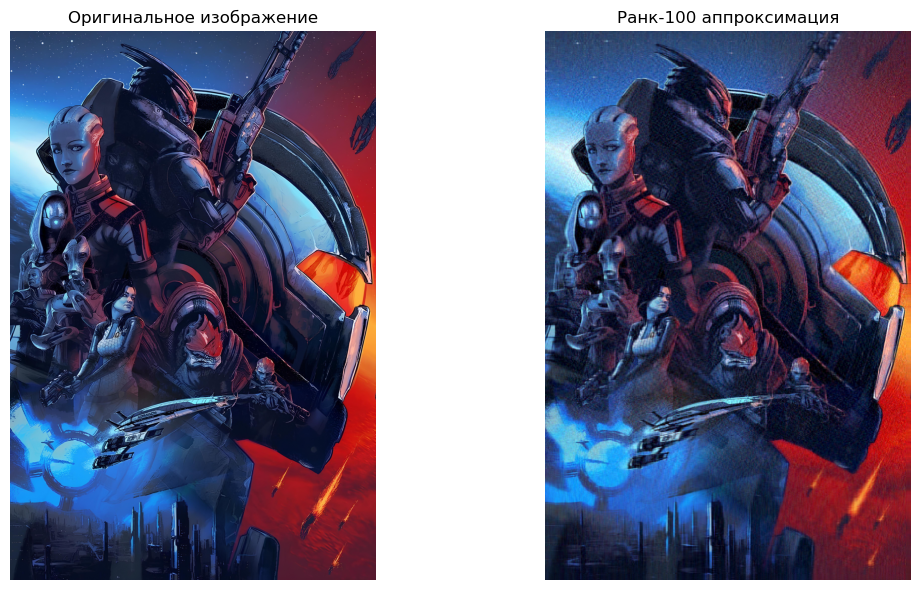

In [28]:
k = 100

R_k = low_rank_approximation(U_R, S_R, Vt_R, k)
G_k = low_rank_approximation(U_G, S_G, Vt_G, k)
B_k = low_rank_approximation(U_B, S_B, Vt_B, k)

# Собираем цветное изображение из приближённых каналов
img_k = reconstruct_image(R_k, G_k, B_k)

# Визуализация: оригинал и приближение рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинал
axes[0].imshow(np.dstack((R, G, B)))
axes[0].set_title('Оригинальное изображение')
axes[0].axis('off')

# Ранковая аппроксимация
axes[1].imshow(img_k)
axes[1].set_title(f'Ранк-{k} аппроксимация')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Подсчет ошибок

In [29]:
err_R = np.linalg.norm(R - R_k, ord='fro')
err_G = np.linalg.norm(G - G_k, ord='fro')
err_B = np.linalg.norm(B - B_k, ord='fro')

err_total = np.sqrt(err_R**2 + err_G**2 + err_B**2)

print(f"Ошибка Фробениуса: R: {err_R:.4f}, G: {err_G:.4f}, B: {err_B:.4f}")
print(f"Суммарная ошибка: {err_total:.4f}")

Ошибка Фробениуса: R: 217.1650, G: 218.6375, B: 221.3073
Суммарная ошибка: 379.3941


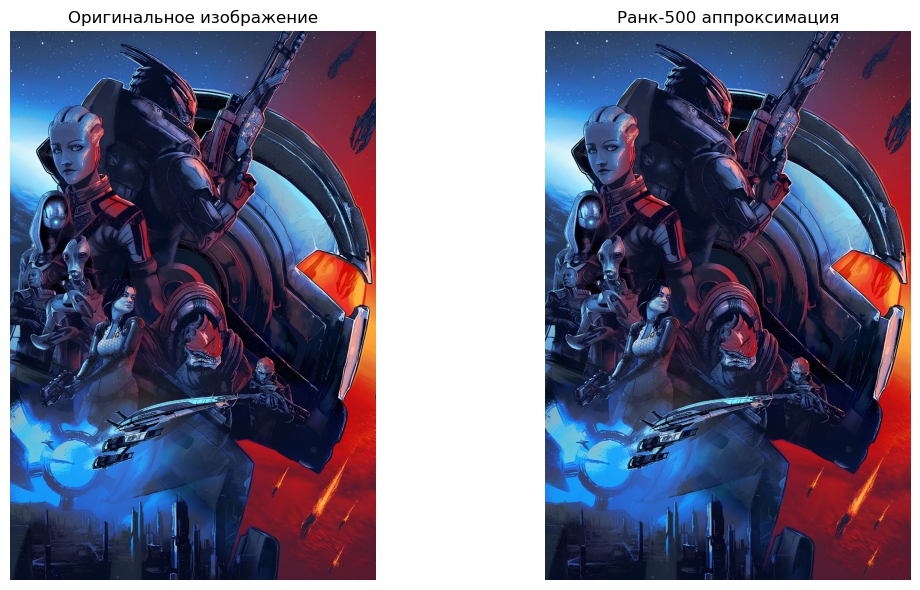

In [30]:
k = 500

R_k = low_rank_approximation(U_R, S_R, Vt_R, k)
G_k = low_rank_approximation(U_G, S_G, Vt_G, k)
B_k = low_rank_approximation(U_B, S_B, Vt_B, k)

# Собираем цветное изображение из приближённых каналов
img_k = reconstruct_image(R_k, G_k, B_k)

# Визуализация: оригинал и приближение рядом
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинал
axes[0].imshow(np.dstack((R, G, B)))
axes[0].set_title('Оригинальное изображение')
axes[0].axis('off')

# Ранковая аппроксимация
axes[1].imshow(img_k)
axes[1].set_title(f'Ранк-{k} аппроксимация')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Подсчет ошибок

In [31]:
err_R = np.linalg.norm(R - R_k, ord='fro')
err_G = np.linalg.norm(G - G_k, ord='fro')
err_B = np.linalg.norm(B - B_k, ord='fro')

err_total = np.sqrt(err_R**2 + err_G**2 + err_B**2)

print(f"Ошибка Фробениуса: R: {err_R:.4f}, G: {err_G:.4f}, B: {err_B:.4f}")
print(f"Суммарная ошибка: {err_total:.4f}")

Ошибка Фробениуса: R: 64.0997, G: 64.9080, B: 64.7096
Суммарная ошибка: 111.8443


### 4.3 График ошибок

In [32]:
ks = [1, 10, 20, 50, 100, 150, 300, 500, 750, 1000]
errors = []
for k_val in ks:
    R_k_temp = low_rank_approximation(U_R, S_R, Vt_R, k_val)
    G_k_temp = low_rank_approximation(U_G, S_G, Vt_G, k_val)
    B_k_temp = low_rank_approximation(U_B, S_B, Vt_B, k_val)
    err_R_temp = np.linalg.norm(R - R_k_temp, ord='fro')
    err_G_temp = np.linalg.norm(G - G_k_temp, ord='fro')
    err_B_temp = np.linalg.norm(B - B_k_temp, ord='fro')
    
    err_total_temp = np.sqrt(err_R_temp**2 + err_G_temp**2 + err_B_temp**2)
    errors.append(err_total_temp)

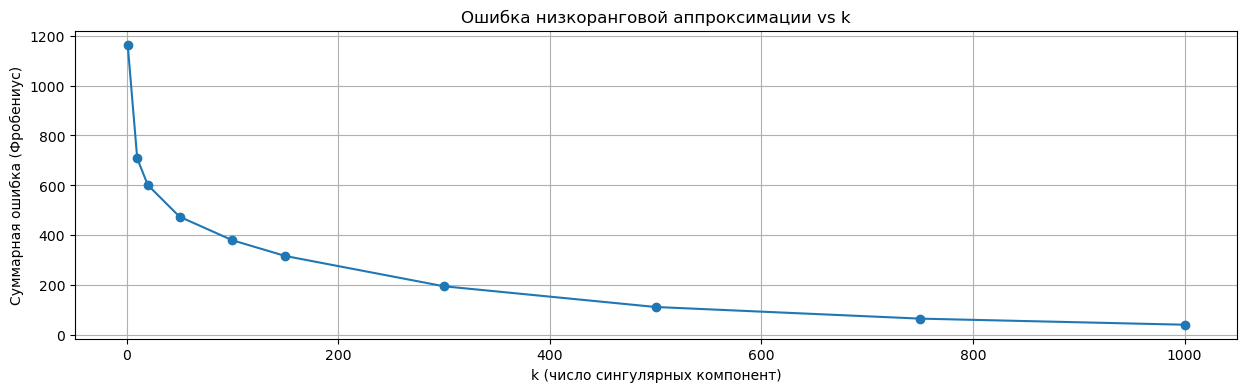

In [33]:
# Построим график зависимости ошибки от k
plt.figure(figsize=(15,4))
plt.plot(ks, errors, marker='o')
plt.xlabel('k (число сингулярных компонент)')
plt.ylabel('Суммарная ошибка (Фробениус)')
plt.title('Ошибка низкоранговой аппроксимации vs k')
plt.grid(True)
plt.show()

## 5. Сравнение с методом Якоби

### 5.1 Реализация функции

In [34]:
def jacobi_eigenvalues(M, tol=1e-8, max_iter=500):
    A = M.copy()
    n = A.shape[0]
    dominant_eig_history = []
    def max_offdiag(A):
        max_val = 0.0
        p = 0; q = 1
        for i in range(n):
            for j in range(i+1, n):
                if abs(A[i, j]) > max_val:
                    max_val = abs(A[i, j]); p, q = i, j
        return p, q, max_val

    for iteration in range(max_iter):
        p, q, max_val = max_offdiag(A)
        if max_val < tol:
            break
        if A[p, p] == A[q, q]:
            phi = np.pi / 4
        else:
            phi = 0.5 * np.arctan2(2*A[p, q], (A[q, q] - A[p, p]))
        c = np.cos(phi); s = np.sin(phi)

        Ap = A.copy()
        for i in range(n):
            if i not in (p, q):
                Ap[i, p] = c*A[i, p] - s*A[i, q]; Ap[p, i] = Ap[i, p]
                Ap[i, q] = s*A[i, p] + c*A[i, q]; Ap[q, i] = Ap[i, q]
        Ap[p, p] = c*c*A[p, p] - 2*s*c*A[p, q] + s*s*A[q, q]
        Ap[q, q] = s*s*A[p, p] + 2*s*c*A[p, q] + c*c*A[q, q]
        Ap[p, q] = 0.0; Ap[q, p] = 0.0
        A = Ap.copy()

        dominant_eig_history.append(np.max(np.diag(A)))

    eigenvalues = np.diag(A)
    return eigenvalues, dominant_eig_history


### 5.2 Применение к каналу R

In [35]:
M_R = R.T @ R
eigvals_R_jacobi, history_R_jacobi = jacobi_eigenvalues(M_R, tol=1e-10, max_iter=500)
singulars_R_jacobi = np.sort(np.sqrt(np.abs(eigvals_R_jacobi)))[::-1]

In [36]:
# Сравним первые 5 σ с NumPy-SVD
print("NumPy SVD (первые 15) :", S_R[:15])
print("Jakobi  (первые 15) :", singulars_R_jacobi[:15])

NumPy SVD (первые 15) : [966.35400385 321.86137414 219.72320533 182.87246507 159.8713544
 111.19014431 106.70042078 100.53709154  92.31537276  88.59451806
  82.01259912  79.81362636  75.87630653  70.70054738  66.63202187]
Jakobi  (первые 15) : [710.76110173  26.5247246   26.45319516  26.4219984   26.30078639
  26.21979847  26.14446453  26.06831471  26.00195687  25.93149109
  25.8221936   25.76499448  25.70460355  25.67277837  25.66199421]


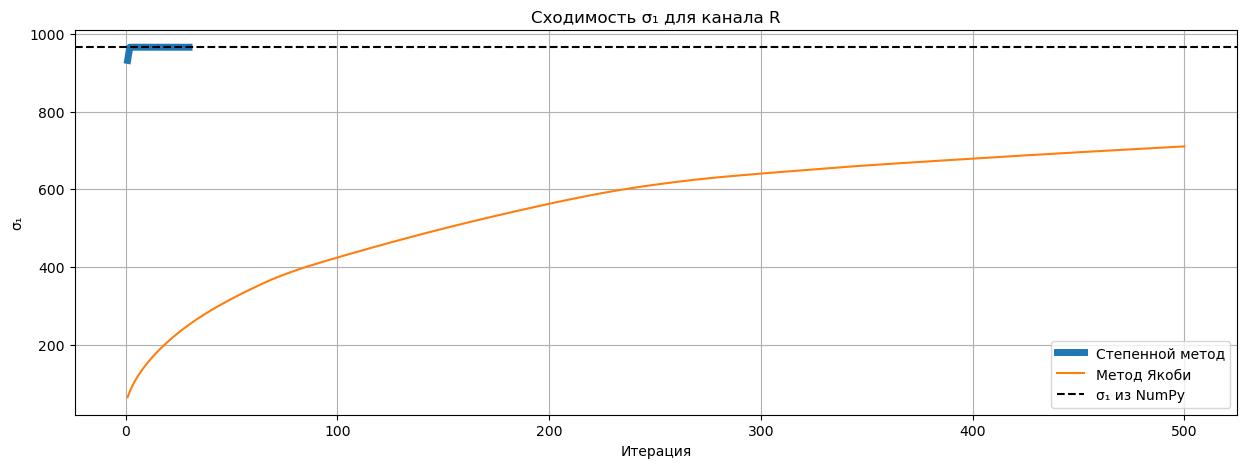

In [53]:
plt.figure(figsize=(15, 5))
it_power = list(range(1, len(sigma_vals_R)+1))
it_jacobi = list(range(1, len(history_R_jacobi)+1))
true_sigma1_R = S_R[0]

plt.plot(it_power, sigma_vals_R, label='Степенной метод', linewidth = 5)
plt.plot(it_jacobi, np.sqrt(history_R_jacobi), label='Метод Якоби')
plt.axhline(true_sigma1_R, color='k', linestyle='--', label='σ₁ из NumPy')
plt.xlabel('Итерация')
plt.ylabel('σ₁')
plt.title('Сходимость σ₁ для канала R')
plt.legend()
plt.grid(True)
plt.show()


### 6. Гистограммы глубины цвета 

Преобразуем R, G, B в диапазон [0,255] для гистограммы 

In [57]:
R_255 = (R * 255).astype(np.uint8)
G_255 = (G * 255).astype(np.uint8)
B_255 = (B * 255).astype(np.uint8)

Рисуем гистограммы

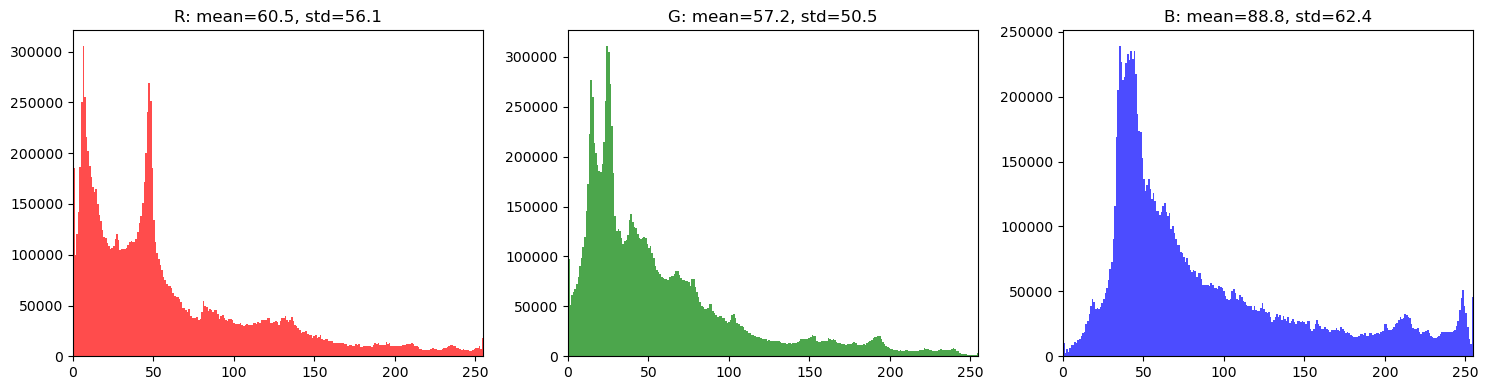

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(R_255.ravel(), bins=256, color='red', alpha=0.7)
axes[0].set_title(f'R: mean={R_255.mean():.1f}, std={R_255.std():.1f}')
axes[0].set_xlim(0,255)

axes[1].hist(G_255.ravel(), bins=256, color='green', alpha=0.7)
axes[1].set_title(f'G: mean={G_255.mean():.1f}, std={G_255.std():.1f}')
axes[1].set_xlim(0,255)

axes[2].hist(B_255.ravel(), bins=256, color='blue', alpha=0.7)
axes[2].set_title(f'B: mean={B_255.mean():.1f}, std={B_255.std():.1f}')
axes[2].set_xlim(0,255)

plt.tight_layout()
plt.show()